<a href="https://colab.research.google.com/github/casparschoen/Stochastic-Volatility-Model-Calibration/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Name: Caspar Schoen***


# Stochastic Alpha Beta Rho (SABR) Model

The SABR model is governed by the following SDEs:
\begin{align}
    dS_t &= \sigma_t S_t^\beta \, dW_t, \\
    d\sigma_t &= \alpha \sigma_t \, dZ_t,
\end{align}

where:

- $S_t$ is the price process at time t
- $\sigma_t$  is the volatility at time $t$,
- $\beta$  is a constant parameter with $0 \leq \beta \leq 1$,
- $\alpha$ is the volatility of volatility,
- $W_t$ and $Z_t$ are two correlated Wiener processes with correlation $\rho$, i.e., $dW_t dZ_t = \rho dt $ .
    
The parameter $\beta$  controls the elasticity of the forward price volatility, while $\alpha$  represents the volatility of the stochastic volatility process $\sigma_t$. The correlation parameter $\rho$ captures the relationship between the forward price and its volatility.

In the specific case, we use the model without the $S_t^\beta$ term:
\begin{align}
    dS_t &= \sigma_t \, dW_t, \\
    d\sigma_t &= \alpha \sigma_t \, dZ_t,
\end{align}

# 1 Generate a time series of K returns from a SABR model (a)
# **(Note that for demonstration a very high negative correlation is chosen to visualize the leverage effect, a well-known stylized fact in financial returns)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor, softmax
from torch.nn import Dropout, Embedding, LayerNorm, Linear, Module, ModuleList, ReLU, Sequential
from typing import List, Any, Protocol
import math
from pathlib import Path
from urllib.request import urlretrieve
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Set model parameters
S0 = 0
v0 = 0.5
alpha = 0.05
beta = 0.2
rho = -0.95
dropoutprob = 0.1
n = 252

In [ ]:
def path_generator(S0: float, v0: float, alpha: float, beta: float, rho: float, n: int = 250, dropout: List[bool] = [False, False], prob: float = 0.0) -> Tensor:
    """Generate a path of length n using the given parameters."""
    path = torch.zeros(n, 2)
    path[0, 0] = S0; path[0, 1] = v0 # path[0, 0] = 100 # process can be <0 but not in Euler scheme

    dt = torch.tensor(1.0 / n).float()
    sqrt_dt = torch.sqrt(dt)
    for i in range(1, n):
        # Correlated random normal variables
        dW_t = torch.randn(1).item()
        dZ_t = rho * dW_t + torch.sqrt(1 - torch.tensor(rho).float()**2) * torch.randn(1).item()

        # S_t = S_{t-1} + alpha * sqrt(dt) * dW_t
        path[i, 0] = path[i - 1, 0] + path[i - 1, 1] * torch.sqrt(dt) * dW_t # * path[i - 1, 0]**beta
        # paths[i, 0] = paths[i -1, 0] * np.exp(( - 0.5 * paths[i-1, 1]**2) * dt + paths[i-1, 1] * sqrt_dt * dZ_t)
        # v_t = v_{t-1} + alpha * sqrt(dt) * dZ_t
        path[i, 1] = np.maximum(path[i - 1, 1] + alpha * path[i - 1, 1] * torch.sqrt(dt) * dZ_t, 0)

        # Euler alternative
        #path[i, 0] = path[i - 1, 0] * np.exp(path[i - 1, 1] * torch.sqrt(dt) * dW_t) # * path[i - 1, 0]**beta
        #path[i, 1] = np.maximum(path[i - 1, 1] *np.exp(alpha * torch.sqrt(dt) * dZ_t),0.001)

    if any(dropout): # Dropout
        for i in range(1, n):
            if dropout[0] and torch.rand(1).item() < prob:
                path[i, 0] = float('nan')
            if dropout[1] and torch.rand(1).item() < prob:
                # No vol available implies no stock price
                path[i, 1] = float('nan')
                path[i, 0] = float('nan')
    # path[:, 0] -=100
    # path[:, 0] +=S0
    return path

In [ ]:
def plot_path(path: Tensor) -> None:
    """Plot the generated path."""
    plt.plot(path[:, 0].numpy(), label='Stock Price')
    plt.legend()
    plt.title('Stock Price Path 252 trading days')
    # Secondary axis
    plt.twinx()
    plt.plot(path[:, 1].numpy(), 'r', label='Volatility')
    plt.xlabel('Trading Days')
    plt.legend()

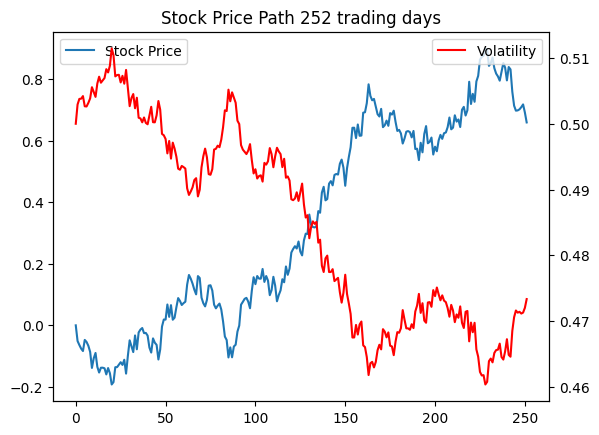

In [ ]:
paths = path_generator(S0, v0, alpha, beta, rho, n, [False, False], dropoutprob)
plot_path(paths)

# Replace some of the returns of S by nan values

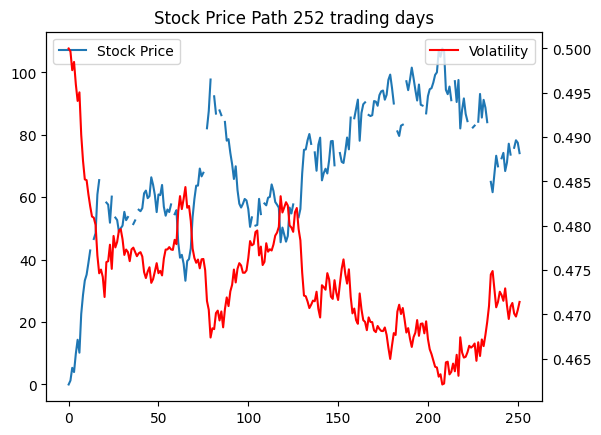

In [ ]:
pathsNA = path_generator(S0, v0, alpha, beta, rho, n, [True, False], dropoutprob)
plot_path(pathsNA)

# Same for Volatility

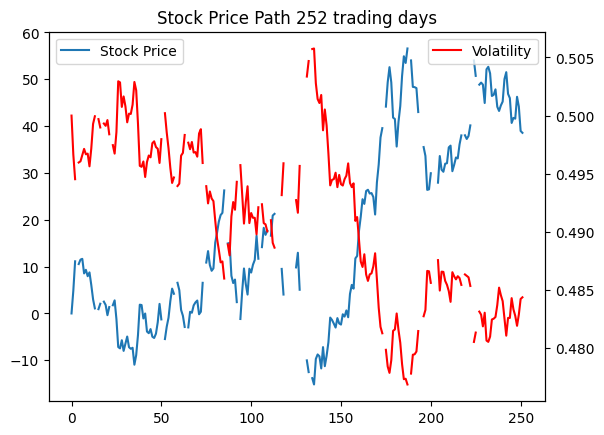

In [ ]:
pathsNA2 = path_generator(S0, v0, alpha, beta, rho, n, [False, True], dropoutprob)
plot_path(pathsNA2)

# Problem Description
The problem arising from a discontinuous time series (missing values) is that the en- and decoding from NA to a logical scalar is non-trivial.

The two most promising patterns to tackle this are to learn a token interpolation which extracts the neighbor values of the time series $X_t$ in case of missing ones and interprets the similarity. Another one is to learn the first difference $\Delta X_t = (1-B)X_t = X_t - X_{t-1}$ where $B$ is referred to as the backshift operator. The idea is to learn the increments of the time series instead of $X_t$ itself. The reason why this makes sense is:

- It can help to make the potentially non-stationary time series stationary (in this case we don't have seasonal or trend components)
- It is easy to find a logical interpretation of missing values, which is trivially that no increment from the past value exists. There is no new information about price changes so the martingale property suggests that the best estimate given the new price is just the last observation under the condition that the path is fully random. Given that $Z_t, W_t$ are Gaussian with $E[Z_t] = E[W_t] = 0$, the increments have zero expectation (but are correlated)
- An interpolation or averaging towards the future value doesn't make sense in the context of Finance, because such values are usually unknown - thus, the model should only interpret the values until $t$ instead of considering $X_{t+1}$.


An approach to interpolate NaNs can be found here: https://github.com/ngruver/llmtime/blob/main/experiments/run_missing.py

It essentially relies on a linear interpolation of NaN values: $np.interp(f(nans), f(~nans), x[~nans])$

To learn the first difference, i.e., the increment structure gave best results compared to learning the plain time series tuples (price / vol).

# Model

The architecture is similar to the GPT style model presented in class. However, some adjustments are needed to make it work in the specific setup.

1. We assume, that a price and vol process are observable. In a real- world setup, the realized volatility can be extracted from the time series. Therefore, we adjust the model to learn a tuple of $List[Tensor, Tensor]$, which contains the pair of volatility and stock price at each $t$. The adjustments are made in the train, loss, batch, generate function respectively.

2. As the input data is a 2-dimensional point, we need to encode this representation and map it to a 1-dimensional key. We adjust the en- and decoder to make predictions which lie again in the 2-dimensional space.

3. We need to account for non-existing values (NaNs) in the price- and vol process. No observable price is interpreted as no existing price increment in the first difference time series and encoded respectively as $(incr_{price} = nan, incr_{vol}) => (0, lastvol)$. Meanwhile, Non existing volatility is encoded as $(incr_{price} , incr_{vol}) => (0, lastvol)$, i.e. the price increment is non-sensical given that no change in realized volatility happend.  

# Results
***Note that only absolute return processes (prices) are plotted because plotting the returns (either log or relative) is nonsensical and the behaviour of the underlying process is not visible. Therefore, we cumulate the returns.***

- The model successfully learned to generate from the underlying stochastic process with a very similar empirical distribution of returns.
- The leverage effect is as set with $\rho$ negative and significant, also very close to the actual set $\rho$ of the model
- Given that the input data was rounded to 3 digits to avoid too many tokens, the generated returns are not as smooth as the ones from the path generator
- This effect is particularly significant for the volatility process - a lot of data is needed to generate a smooth forecast.

# Adjusted Boilerplate code
(Adjusted from code shown in class to account for tuples and different encoding of inputs)

In [ ]:
class TokenEmbedding(Module):
    """A trainable mapping from integers into a vector space."""
    def __init__(self, *, C: int, E: int = 64, T_max: int = 32, **_: Any) -> None:
        super().__init__()
        self.token_embedding = Embedding(C, E)
        self.position_embedding = Embedding(T_max, E)

    def forward(self, x: Tensor) -> Tensor:
        B, T = x.shape
        x = self.token_embedding(x)  # (B, T, C) -> (B, T, E)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))  # (T, E)
        return x + pos_emb  # (B, T, E)



class PositionEncoding(Module):
    """A non-trainable encoding of token positions as sines and cosines."""
    def __init__(self, *, F: int, T_max: int = 5000, **_: Any):
        super().__init__()
        position = torch.arange(T_max).unsqueeze(1) # (T_max, 1)
        frequencies = torch.exp(torch.arange(0, F, 2) * (-math.log(2.*T_max) / F)) # (ceil(F/2), )
        pe = torch.zeros(T_max, F)
        pe[:, 0::2] = torch.sin(position * frequencies) # (T_max, ceil(F/2))
        pe[:, 1::2] = torch.cos(position * frequencies)[:, :math.floor(0.5*F)] # (T_max, floor(F/2))
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        B, T, E = x.shape
        T_max, F = self.pe.shape
        pe = self.pe[: T].unsqueeze(0).expand(B, T, F) # (T_max, F) -> (B, T, F)
        return torch.cat([x, pe[: x.size(0)]], dim=-1) # (B, T, E+F)


import torch.distributions.utils
class Output(Protocol):
    def __init__(self, _: Tensor) -> None: ...

    def log_prob(self, _: Tensor) -> Tensor: ...

    def sample(self) -> Tensor: ...


class CategoricalOutput(torch.distributions.Categorical):
    def __init__(self, x: Tensor) -> None:
        super().__init__(logits=x)


In [ ]:
class AttentionHead(Module):
    """One head of self-attention.

    Shape parameters: batch size B, lenght of token sequence T, maximal length of token sequence T_max
    number of characters C, embedding dimension E, projected embedding dimension P.
    """

    def __init__(self, E: int, P: int, T_max: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.key = Linear(E, P, bias=False)
        self.query = Linear(E, P, bias=False)
        self.value = Linear(E, P, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(T_max, T_max)))
        self.dropout = Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        B, T, E = x.shape
        # apply linear layers query, key, and value
        q = self.query(x)  # (B, T, E) -> (B, T, P)
        k = self.key(x)  # (B, T, E) -> (B, T, P)
        v = self.value(x)  # (B, T, E) -> (B, T, P)
        # compute attention scores
        attention = q @ k.transpose(-2, -1) * E**-0.5  # (B, T, P) @ (B, P, T) -> (B, T, T)
        attention = attention.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)
        attention = softmax(attention, dim=-1)  # (B, T, T)
        attention = self.dropout(attention)  # (B, T, T)
        # aggregate the attention-weighted values
        return attention @ v  # (B, T, T) @ (B, T, P) -> (B, T, P)


class AttentionLayer(Module):
    """Multiple heads of self-attention in parallel.

    Shape parameters: embedding dimension E, projected embedding dimension P,
    number of attention heads H, maximal length of token sequence T_max, number of characters C.
    """

    def __init__(self, E: int, H: int, P: int, T_max: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.heads = ModuleList([AttentionHead(E, P, T_max) for _ in range(H)])
        self.proj = Linear(H * P, H * P)
        self.dropout = Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # (B, T, E) -> (B, T, H*P)
        return self.dropout(self.proj(out))  # (B, T, H*P)


class FeedFoward(Module):
    """A fully connected feed-forward network with one hidden layer.

    Shape parameters: embedding dimension E.
    """

    def __init__(self, E: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.net = Sequential(
            Linear(E, 4 * E),
            ReLU(),
            Linear(4 * E, E),
            Dropout(dropout),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class TransformerBlock(Module):
    """Transformer block: communication followed by computation.

    Shape parameters: embedding dimension E, projected embedding dimension P,
    number of attention heads H, maximal length of token sequence T_max.
    """

    def __init__(self, E: int, H: int, T_max: int) -> None:
        super().__init__()
        assert E % H == 0
        P = E // H
        self.attention_layer = AttentionLayer(E, H, P, T_max)
        self.feed_forward = FeedFoward(E)
        self.layer_norm1 = LayerNorm(E)
        self.layer_norm2 = LayerNorm(E)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.attention_layer(self.layer_norm1(x))  # (B, T, E) -> (B, T, E)
        return x + self.feed_forward(self.layer_norm2(x))  # (B, T, E) -> (B, T, E)

# adjusted
class GPT(Module):
    """GPT-style transformer (decoder-only) with token and positional embeddings.

    Shape parameters: number of distribution parameters D, embedding dimension E,
    number of attention heads H, number of attention layers L, maximal length of token sequence T_max,
    length of predicted sequence T_pred.
    """

    def __init__(
        self,
        embedding: Module,
        *,
        D: int | list[int],
        E: int = 64,
        H: int = 4,
        L: int = 4,
        T_max: int = 32,
        output: type[Output] = CategoricalOutput,
        **_: Any,
    ) -> None:
        super().__init__()
        self.embedding = embedding
        self.transformer_blocks = Sequential(*[TransformerBlock(E, H, T_max) for _ in range(L)])
        self.layer_norm = LayerNorm(E)  # final layer norm
        self.linear = Linear(E, math.prod(D) if isinstance(D, list) else D)
        self.distribution = output
        self.D = D
        self.T_max = T_max

    def forward(self, x: Tensor, targets: Tensor | None = None) -> tuple[Tensor, Tensor | None]:
        x = self.embedding(x) # (B, T, E)
        x = self.transformer_blocks(x)  # (B, T, E) -> (B, T, E)
        x = self.layer_norm(x)  # (B, T, E)
        x = self.linear(x)  # (B, T, D)
        if isinstance(self.D, list):
            x = x.view(x.shape[0], x.shape[1], *self.D) # (B, T, D1, ..., Dn)
        loss = None if targets is None else -self.distribution(x).log_prob(targets).mean()
        return x, loss

    def generate(self, x: Tensor, T_pred: int) -> Tensor:
        # x has shape (B, T, ...)
        for _ in range(T_pred):
            # crop idx to the last block_size tokens
            x_cropped = x[:, -self.T_max :]  # (B, T_cropped, ...)
            # get the predictions
            y, _ = self(x_cropped)  # (B, T_cropped, ...)
            # focus only on the last time step
            y = y[:, -1, :]  # (B, ...)
            # sample from the distribution
            y = self.distribution(y).sample().unsqueeze(1)  # (B, 1, ...)
            # append sampled index to the running sequence
            x = torch.cat((x, y), dim=1)  # (B, T+1, ...)
        return x

In [ ]:
# adjusted
def get_batch(data: list[tuple[float, float]], config: dict) -> tuple[Tensor, Tensor]:
    B = config.get("B", 16)
    T_max = config.get("T_max", 32)
    device = config.get("device", "cuda" if torch.cuda.is_available() else "cpu")
    # print("data len", len(data))
    # print("tmax", T_max)
    ix = torch.randint(len(data) - T_max, (B,))
    x = torch.stack([data[i : i + T_max] for i in ix])
    y = torch.stack([data[i + 1 : i + T_max + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# adjusted
@torch.no_grad()
def estimate_loss(model: Module, train_data: list[tuple[float, float]], val_data: Tensor, config: dict) -> dict:
    eval_iters = config.get("eval_iters", 200)
    out = {}
    model.eval()
    for split in ["train", "val"]:
        data = train_data if split == "train" else val_data
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(data, config)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def train(model: Module, text: str, config: dict) -> None:
    # unpack config
    learning_rate = config.get("learning_rate", 1e-3)
    max_iters = config.get("max_iters", 5000)
    dtype = config.get("dtype", torch.long)
    encode = config.get("encode")
    eval_interval = config.get("eval_interval", 100)
    split = config.get("split")
    transform = config.get("transform")


    data = torch.as_tensor(text if encode is None else encode(text), dtype=dtype)
    if split is None:
        split = int(0.9 * len(data))
    train_data = data[:split]
    val_data = data[split:]

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for i in range(max_iters):

        # every once in a while evaluate the loss on train and val sets
        if i % eval_interval == 0 or i == max_iters - 1:
            losses = estimate_loss(model, train_data, val_data, config)
            print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        x, y = get_batch(train_data, config)

        # optionally transform the targets
        if transform is not None:
            y = transform(y)

        # evaluate the loss
        _, loss = model(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

# adjusted
@torch.no_grad()
def generate(model: Module, x: list[tuple[float, float]], config: dict) -> list[tuple[float, float]]:
    # unpack config
    encode = config.get("encode")
    decode = config.get("decode")
    device = config.get("device", "cuda" if torch.cuda.is_available() else "cpu")
    dtype = config.get("dtype", torch.long)
    T_pred = config.get("T_pred", 1000)

    x_encoded = encode(x)
    x_encoded = torch.as_tensor(x_encoded, dtype=dtype, device=device).unsqueeze(0)
    y = model.generate(x_encoded, T_pred)[0].tolist()

    y = decode(y)
    return y

# Generate Price Paths (b)
The model is trained NOT to output NaNs as described in the lecture

In [ ]:
pathsnew = path_generator(S0, v0, alpha, beta, rho, int(1e5), [True, False], dropoutprob)
timeseries = pathsnew[:,0].numpy().astype(np.float64) # not using log in order to avoid numerical issues

In [ ]:
mask = np.isnan(timeseries)
valid_indices = np.maximum.accumulate(np.where(~mask, np.arange(len(timeseries)), 0))
timeseries[mask] = timeseries[valid_indices[mask]]
timeseriesvol = pathsnew[:,1].numpy().astype(np.float64)
timeseriesvol[mask] = timeseriesvol[valid_indices[mask]]

timeseriesvol = np.round(timeseriesvol,3)
timeseries = np.round(timeseries,3)

#first difference
timeseries = np.diff(timeseries)
timeseriesvol = np.diff(timeseriesvol)

In [ ]:
# make tuples from 2 arrays, given that we have a combination of (x,y) much more tuples are needed for a good grid compared to the example shown in class
tuples = list(zip(timeseries, timeseriesvol))
# take unique tuples
unique_tuples = list(set(tuples))

# sort tuples
unique_tuples = sorted(unique_tuples)
# dicts for encoding and decoding
stoi = {ch: i for i, ch in enumerate(unique_tuples)}
itos = {i: ch for i, ch in enumerate(unique_tuples)}

import math
def encode(tuples): # take a list of (price, vol) tuples, output a list of integers
    # Encode tuples of (float(nan), y) as (0, y) because no increment available implies no stock price
    tuples = [(0, y) if math.isnan(x) else (x, y) for x, y in tuples]
    return [stoi[t] for t in tuples]

def decode(encoded_list): # take a list of integers, output a list of (price, vol) tuples
    return [itos[i] for i in encoded_list]

# Test
encoded = encode(unique_tuples)
print("Encoded:", encoded)

decoded = decode(encoded)
print("Decoded:", decoded)

print(len(unique_tuples))

Encoded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [ ]:
# GOOD LEARNING PROGRESS WITH THESE PARAMETERS
config = {
    "C": len(unique_tuples),
    "D": len(unique_tuples),
    "E": 128, #64, #128
    "T_pred": 252,
    "encode": encode,
    "decode": decode,
    "max_iters": 300,     # less training to avoid divergence
}
embedding = TokenEmbedding(**config).to(device)
model = GPT(embedding, **config).to(device)
print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())/1e6} M")
train(model, tuples, config)

Number of model parameters: 0.856813 M
step 0: train loss 5.7420, val loss 5.7436
step 100: train loss 2.4080, val loss 2.6749
step 200: train loss 2.3668, val loss 2.5747
step 299: train loss 2.3420, val loss 2.5102


In [ ]:
output = generate(model, list(zip(timeseries[3:4], timeseriesvol[4:5])), config)

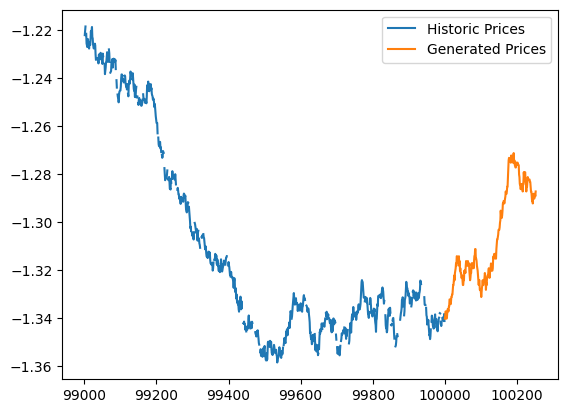

In [ ]:
stock = [i[0] for i in output]
vol = [i[1] for i in output]
# NOTE that the last value is the last value of the historic data which is added to the generated data
plt.plot(np.arange(len(pathsnew)-999,len(pathsnew)),pathsnew[-1000:-1, 0].numpy(), label='Historic Prices')
plt.plot(np.arange(len(pathsnew),len(pathsnew)+len(output)),np.cumsum(stock)+float(pathsnew[valid_indices[-1],0]), label='Generated Prices')
plt.legend()

# Another Example (Run Second time)

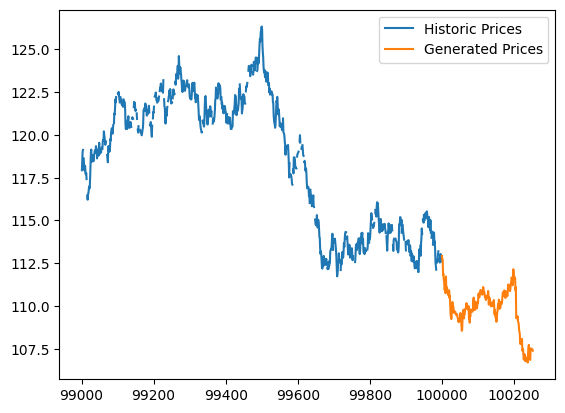

In [ ]:
stock = [i[0] for i in output]
vol = [i[1] for i in output]
# NOTE that the last value is the last value of the historic data which is added to the generated data
plt.plot(np.arange(len(pathsnew)-999,len(pathsnew)),pathsnew[-1000:-1, 0].numpy(), label='Historic Prices')
plt.plot(np.arange(len(pathsnew),len(pathsnew)+len(output)),np.cumsum(stock)+float(pathsnew[valid_indices[-1],0]), label='Generated Prices')
plt.legend()

# **As mentioned, looking at the returns of the process doesn't say much about the underlying dynamics**

Text(0.5, 1.0, 'Price Returns (Increments)')

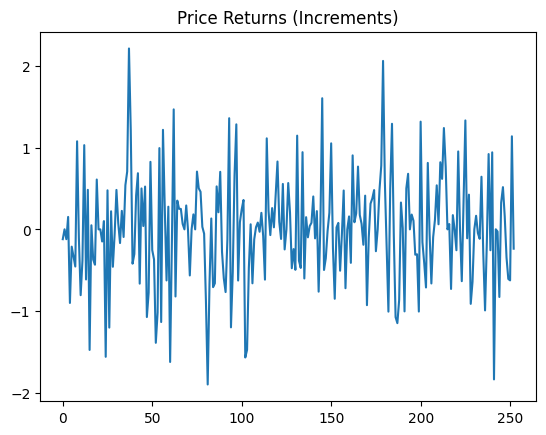

In [ ]:
plt.plot(stock)
plt.title("Price Returns (Increments)")

# Another Third Example (code run another time)

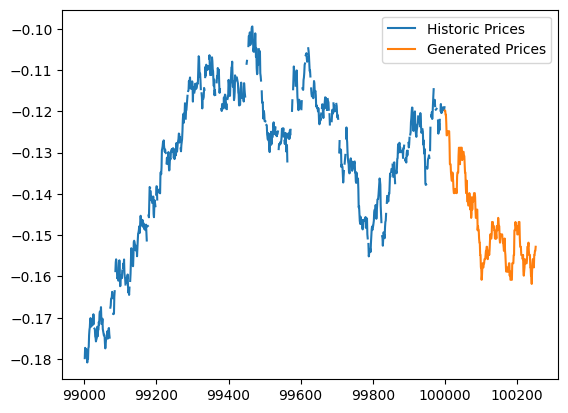

In [ ]:
stock = [i[0] for i in output]
vol = [i[1] for i in output]
# NOTE that the last value is the last value of the historic data which is added to the generated data
plt.plot(np.arange(len(pathsnew)-999,len(pathsnew)),pathsnew[-1000:-1, 0].numpy(), label='Historic Prices')
plt.plot(np.arange(len(pathsnew),len(pathsnew)+len(output)),np.cumsum(stock)+float(pathsnew[valid_indices[-1],0]), label='Generated Prices')
plt.legend()

# Distribution of Increments Historical vs Simulated (nearly identical)
(Note that the frequency shape and not the frequency magnitude matters as the size of datapoints significantly differs)

(array([4.2000e+01, 2.6100e+02, 1.7020e+03, 1.0097e+04, 3.2100e+04,
        4.3456e+04, 1.0220e+04, 1.8000e+03, 2.7600e+02, 2.9000e+01]),
 array([-1.5, -1.2, -0.9, -0.6, -0.3,  0. ,  0.3,  0.6,  0.9,  1.2,  1.5]),
 <BarContainer object of 10 artists>)

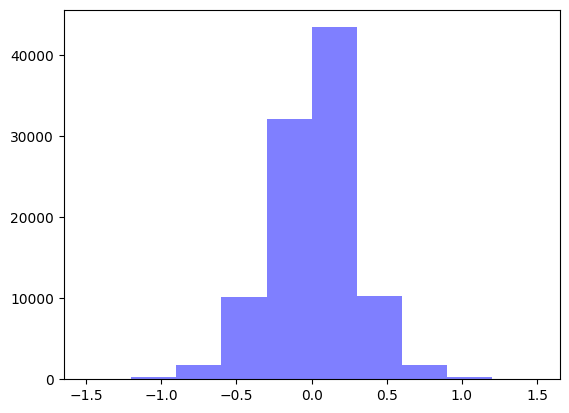

In [ ]:
stock = [i[0] for i in output]
vol = [i[1] for i in output]

# HISTORICAL
plt.hist(timeseries, color="blue", bins=10, alpha=0.5, range=(-1.5, 1.5))

(array([  0.,   0.,   7.,  24.,  84., 113.,  20.,   3.,   1.,   0.]),
 array([-1.5, -1.2, -0.9, -0.6, -0.3,  0. ,  0.3,  0.6,  0.9,  1.2,  1.5]),
 <BarContainer object of 10 artists>)

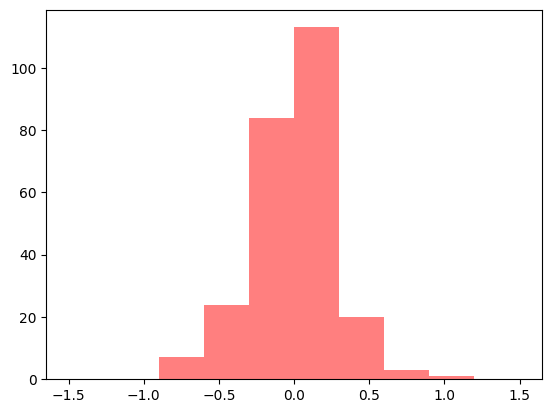

In [ ]:
# SIMULATED
plt.hist(np.array(stock), color="red", bins=10, alpha=0.5, range=(-1.5, 1.5))

# Correlation Check shows that negative correlation of increments is learned

**DISREGARD THIS, THE CHECK IS REPEATED AT C) WITH BETTER PRECISION**

In c), it is even visible that the 2 time series have a highly negative correlation in line with the chosen $\rho$

In [ ]:
# Check correlation, real and estimated negative and around -0.95
# CHECK IS REPEADED IN SECTION C) WITH BETTER PRECISION
stockdiff = np.diff(stock)
voldiff = np.diff(vol)
corr_est = np.corrcoef(stockdiff, voldiff)
print("True correlation:", rho)
print("Estimated correlation:", corr_est[0,1])

True correlation: -0.95
Estimated correlation: -0.9168998701770649


# No Volatility Available (c)

In [ ]:
pathsnew = path_generator(S0, v0, alpha, beta, rho, int(1e4), [False, True], dropoutprob)
timeseries = pathsnew[:,0].numpy().astype(np.float64) # not using log in order to avoid numerical issues
timeseriesvol = pathsnew[:,1].numpy().astype(np.float64)
mask = np.isnan(timeseriesvol)
valid_indices = np.maximum.accumulate(np.where(~mask, np.arange(len(timeseriesvol)), 0))
timeseries[mask] = timeseries[valid_indices[mask]]
timeseriesvol[mask] = timeseriesvol[valid_indices[mask]]
timeseriesvol = np.round(timeseriesvol,3)
timeseries = np.round(timeseries,3)

#first difference
timeseries = np.diff(timeseries)
timeseriesvol = np.diff(timeseriesvol)

In [ ]:
# make tuples from 2 arrays
tuples = list(zip(timeseries, timeseriesvol))
# take unique tuples
unique_tuples = list(set(tuples))

# sort tuples
unique_tuples = sorted(unique_tuples)
# dicts for encoding and decoding
stoi = {ch: i for i, ch in enumerate(unique_tuples)}
itos = {i: ch for i, ch in enumerate(unique_tuples)}

import math
def encode(tuples): # take a list of (price, vol) tuples, output a list of integers
    # Encode tuples of (x, float(nan)) as (0, 0) because no vol available implies no stock price
    tuples = [(0, 0) if math.isnan(y) else (x, y) for x, y in tuples]
    return [stoi[t] for t in tuples]

def decode(encoded_list): # take a list of integers, output a list of (price, vol) tuples
    return [itos[i] for i in encoded_list]

# Test
encoded = encode(unique_tuples)
print("Encoded:", encoded)

decoded = decode(encoded)
print("Decoded:", decoded)

print(len(unique_tuples))

Encoded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [ ]:
# NICE LEARNING PROCESS EVEN WITH SHORT TRAINING, LONGER TRAINING WORKS AS WELL
config = {
    "C": len(unique_tuples),        # how many characters?
    "D": len(unique_tuples),        # how many distributional parameters?
    "E": 128, #64, #128                       # more embeddings per token
    "T_pred": 252,                  # more predictions
    "encode": encode,
    "decode": decode,
    "max_iters": 50,     # very short training for efficiency and to avoid overfitting
}
embedding = TokenEmbedding(**config).to(device)
model = GPT(embedding, **config).to(device)
print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())/1e6} M")
train(model, tuples, config)

Number of model parameters: 0.86992 M
step 0: train loss 5.8427, val loss 5.8402
step 49: train loss 3.6621, val loss 3.7089


In [ ]:
output = generate(model, list(zip(timeseries[3:4], timeseriesvol[4:5])), config)

In [ ]:
# Extracting stock and vol from the output
stock = [i[0] for i in output]
vol = [i[1] for i in output]

# Volatility Clearly Not as Smooth as Price Process
- The leverage effect (negative $\rho$) is even visible in the chart
- There was a noticable impact of the number of embeddings $E$ on the smoothness of the time series.
- Few embeddings learn a very simple representation while a highly parametrized model with E around 512 learned a very noisy process
- However, it is hard to interpret if the highly noisy model with 10m+ parameters lears something useful. The training and validation error for models with small $E$ converges to zero with increasing interations while the model output is nonsensical. Thats why a robust $E$ was chosen and a less smooth vol path generated while the price process is still very smooth.
- Training didnt converge but rather diverge with too many parameters while error converged for too simple models

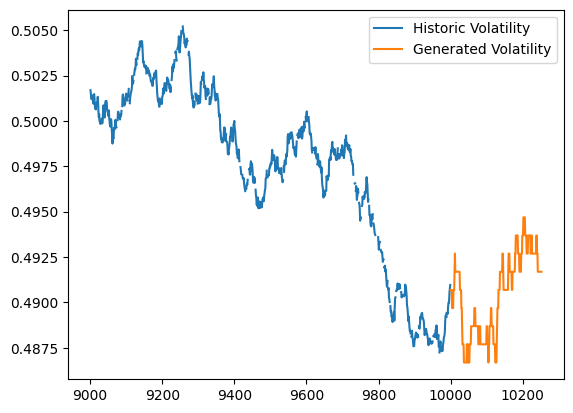

In [ ]:
plt.plot(np.arange(len(pathsnew)-999,len(pathsnew)),pathsnew[-1000:-1, 1].numpy(), label='Historic Volatility')
plt.plot(np.arange(len(pathsnew),len(pathsnew)+len(output)),np.cumsum(vol)+float(pathsnew[valid_indices[-1],1]), label='Generated Volatility')
plt.legend()

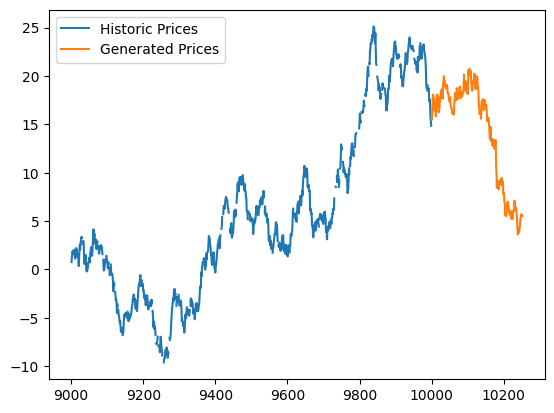

In [ ]:
stock = [i[0] for i in output]
vol = [i[1] for i in output]
# NOTE that the last value is the last value of the historic data which is added to the generated data
plt.plot(np.arange(len(pathsnew)-999,len(pathsnew)),pathsnew[-1000:-1, 0].numpy(), label='Historic Prices')
plt.plot(np.arange(len(pathsnew),len(pathsnew)+len(output)),np.cumsum(stock)+float(pathsnew[valid_indices[-1],0]), label='Generated Prices')
plt.legend()

In [ ]:
# Check correlation, real and estimated negative and around -0.95
stockdiff = np.diff(stock)
voldiff = np.diff(vol)
corr_est = np.corrcoef(stockdiff, voldiff)
print("True correlation:", rho)
print("Estimated correlation:", corr_est[0,1])

True correlation: -0.95
Estimated correlation: -0.4712375482460389
